# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by Bertelsmann Arvato Analytics.

In [77]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [78]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter = ";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter = ";")

In [79]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [81]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [82]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [83]:
feat_info.head(10)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [84]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,SEMIO_SOZ,person,ordinal,[-1]
freq,1,43,49,26


In [85]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

In [86]:
# Identify missing or unknown data values and convert them to NaNs.

import ast
# Get the content of attribute column from feat_info

missing_unknown_list = feat_info["attribute"].tolist()
print(missing_unknown_list)

['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'KBA05

In [87]:
# Missing data in azdias before
azdias.isna().sum().sum()

4896838

In [88]:
# Replace required values in azdias with NaN

for mu in missing_unknown_list:
    result = feat_info.loc[feat_info["attribute"] == mu, "missing_or_unknown"]
    result_str = result.tolist()[0]
    #print(result_str)
    if "XX" in result_str:
        result_str = result_str.replace("XX", "'" + "XX" + "'")
    elif "X" in result_str:
        result_str = result_str.replace("X", "'" + "X" + "'")
    #print(result_str)
    
    result_list = ast.literal_eval(result_str)    
    if len(result_list) != 0: 
        print(mu,result_list)        
        for r in result_list:
            azdias[mu] = np.where(azdias[mu] == r, np.nan, azdias[mu])

AGER_TYP [-1, 0]
ALTERSKATEGORIE_GROB [-1, 0, 9]
ANREDE_KZ [-1, 0]
CJT_GESAMTTYP [0]
FINANZ_MINIMALIST [-1]
FINANZ_SPARER [-1]
FINANZ_VORSORGER [-1]
FINANZ_ANLEGER [-1]
FINANZ_UNAUFFAELLIGER [-1]
FINANZ_HAUSBAUER [-1]
FINANZTYP [-1]
GEBURTSJAHR [0]
HEALTH_TYP [-1, 0]
LP_LEBENSPHASE_FEIN [0]
LP_LEBENSPHASE_GROB [0]
LP_FAMILIE_FEIN [0]
LP_FAMILIE_GROB [0]
LP_STATUS_FEIN [0]
LP_STATUS_GROB [0]
NATIONALITAET_KZ [-1, 0]
PRAEGENDE_JUGENDJAHRE [-1, 0]
RETOURTYP_BK_S [0]
SEMIO_SOZ [-1, 9]
SEMIO_FAM [-1, 9]
SEMIO_REL [-1, 9]
SEMIO_MAT [-1, 9]
SEMIO_VERT [-1, 9]
SEMIO_LUST [-1, 9]
SEMIO_ERL [-1, 9]
SEMIO_KULT [-1, 9]
SEMIO_RAT [-1, 9]
SEMIO_KRIT [-1, 9]
SEMIO_DOM [-1, 9]
SEMIO_KAEM [-1, 9]
SEMIO_PFLICHT [-1, 9]
SEMIO_TRADV [-1, 9]
SHOPPER_TYP [-1]
SOHO_KZ [-1]
TITEL_KZ [-1, 0]
VERS_TYP [-1]
ZABEOTYP [-1, 9]
ALTER_HH [0]
HH_EINKOMMEN_SCORE [-1, 0]
KK_KUNDENTYP [-1]
W_KEIT_KIND_HH [-1, 0]
WOHNDAUER_2008 [-1, 0]
ANZ_HAUSHALTE_AKTIV [0]
GEBAEUDETYP [-1, 0]
MIN_GEBAEUDEJAHR [0]
OST_WEST_KZ [-1]
WOHNL

In [89]:
#azdias["AGER_TYP"] = np.where(azdias["AGER_TYP"] == -1, np.nan, azdias["AGER_TYP"])
azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1.0,3.0,3.0,3.0,4.0,1.0,3.0,2.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1.0,3.0,4.0,4.0,2.0,4.0,2.0,2.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2.0,4.0,2.0,4.0,2.0,3.0,5.0,4.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [90]:
# After NaN replacement, analyze missing data

azdias.isna().sum().sum()

8373929

Number of missing data is now more after replacement of values

#### Step 1.1.2: Assess Missing Data in Each Column

In [91]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
na_count = azdias.isna().sum()/azdias.shape[0] * 100

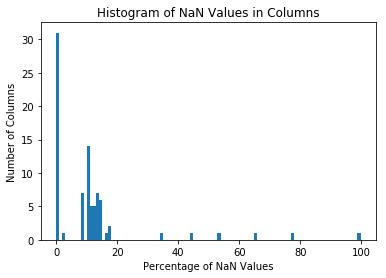

In [92]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(na_count, bins=100)
plt.xlabel('Percentage of NaN Values')
plt.ylabel('Number of Columns')
plt.title('Histogram of NaN Values in Columns')
plt.show()

In [93]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Keeping columns under 20% missing values

filtered_cols = na_count[na_count<20].index
azdias = azdias[filtered_cols]
azdias.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,4.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,1.0,1.0,3.0,3.0,3.0,4.0,1.0,3.0,2.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,3.0,1.0,3.0,4.0,4.0,2.0,4.0,2.0,2.0,6.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,3.0,2.0,4.0,2.0,4.0,2.0,3.0,5.0,4.0,1.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [94]:
removed_cols = na_count[na_count>20].index
print(removed_cols)

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')


#### Discussion 1.1.2: Assess Missing Data in Each Column

The majority of columns have less than 20% missing data. The remaining columns are outliers which have been removed such as: 
'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP','KBA05_BAUMAX'

#### Step 1.1.3: Assess Missing Data in Each Row

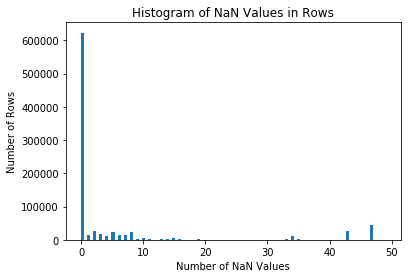

In [95]:
# How much data is missing in each row of the dataset?

row_null_counts = azdias.isnull().sum(axis=1)
#print(row_null_counts)

plt.hist(row_null_counts, bins=100)
plt.xlabel('Number of NaN Values')
plt.ylabel('Number of Rows')
plt.title('Histogram of NaN Values in Rows')
plt.show()

In [96]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Subset of data with rows containing row missing values <= 20
subset1 = azdias[azdias.isnull().sum(axis=1) <= 20]

# Subset of data with rows containing row missing values > 20
subset2 = azdias[azdias.isnull().sum(axis=1) > 20]

In [97]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

import random

column_names = azdias.columns.tolist()

# Randomly selecting 10 columns
slct_columns = random.sample(column_names, 10)
print(slct_columns)

['SEMIO_RAT', 'EWDICHTE', 'ARBEIT', 'CAMEO_DEUG_2015', 'PLZ8_BAUMAX', 'ORTSGR_KLS9', 'SEMIO_FAM', 'SEMIO_REL', 'FINANZ_MINIMALIST', 'ZABEOTYP']


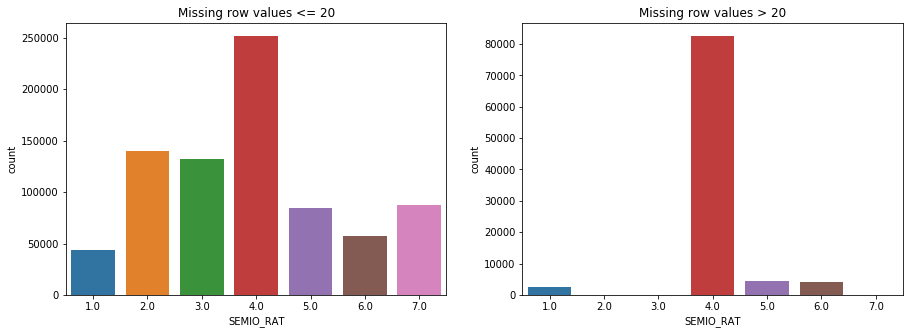

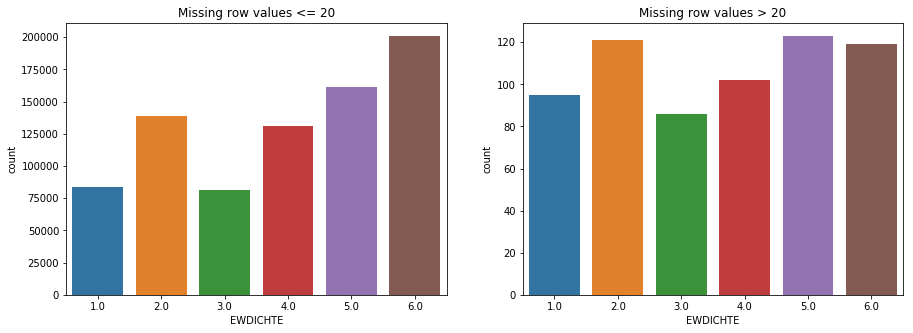

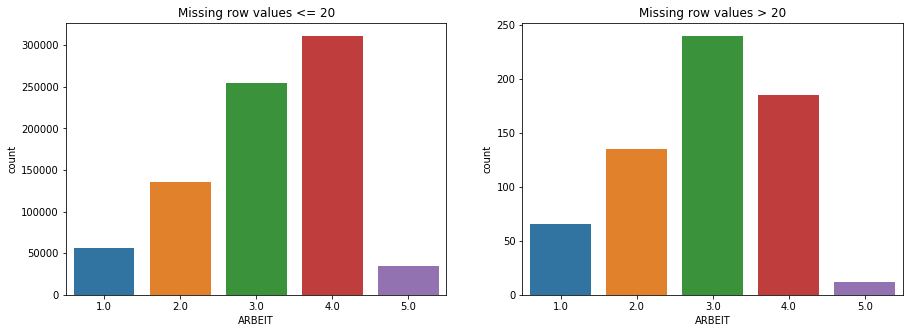

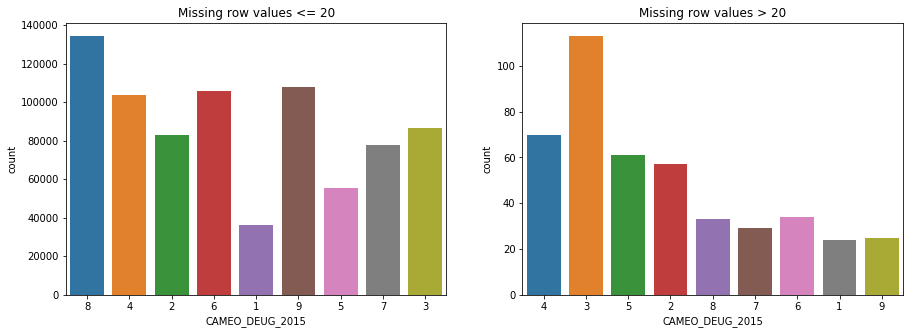

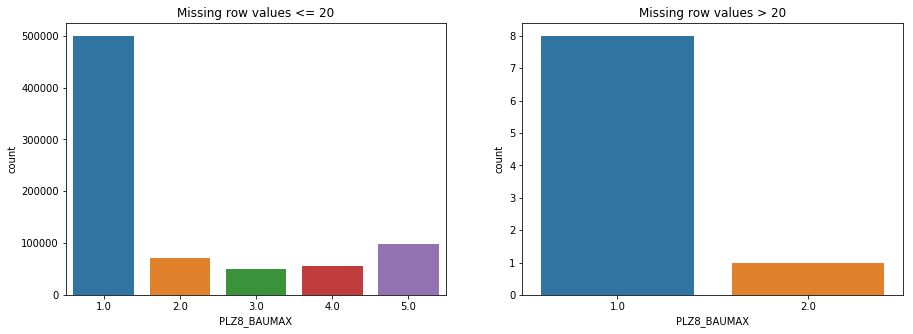

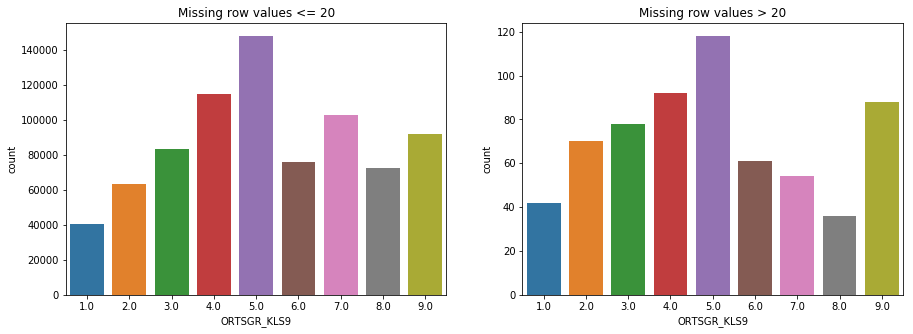

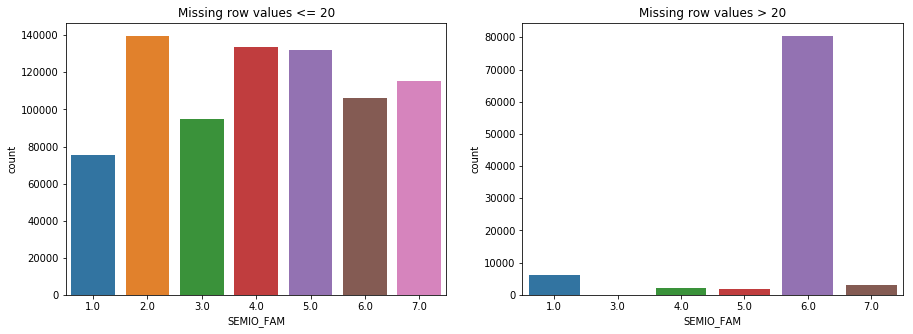

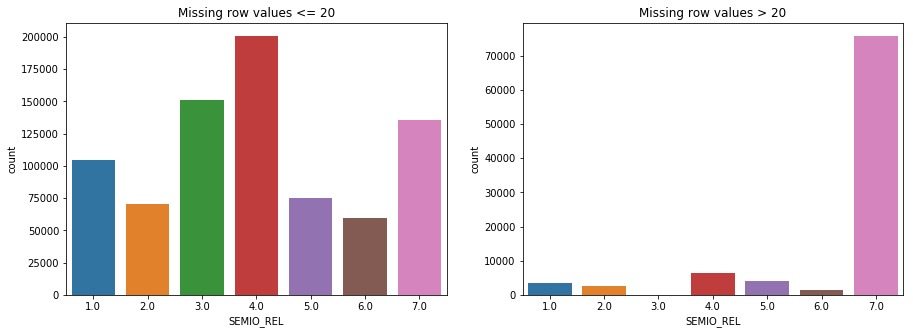

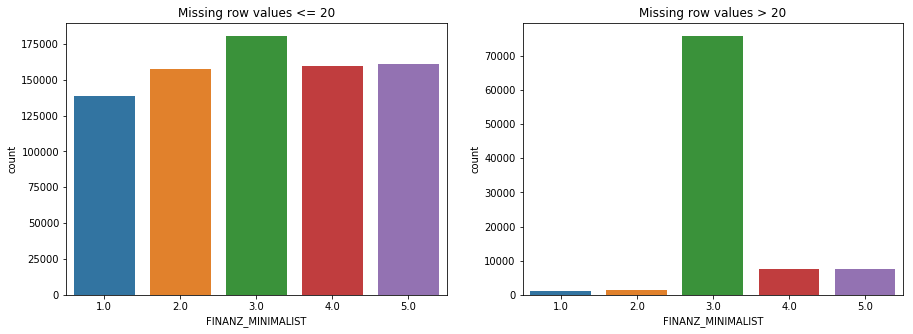

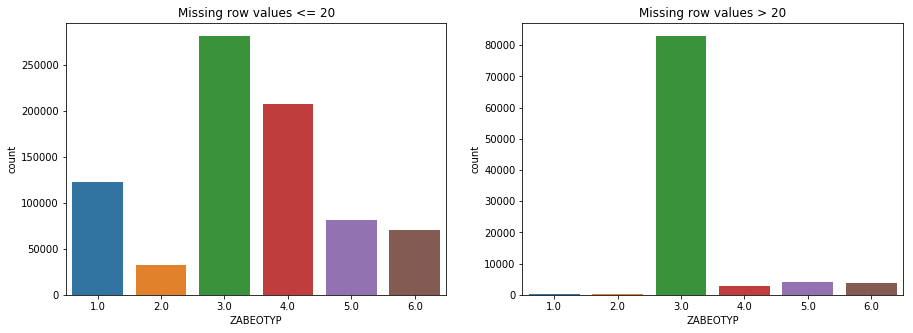

In [98]:

for i in slct_columns:
    # Create 2x2 grid of subplots
    fig, ax = plt.subplots(1,2, figsize = (15,5))
    
    sns.countplot(x=i, data=subset1, ax=ax[0])
    sns.countplot(x=i, data=subset2, ax=ax[1])
    
    # Plot data in the first subplot
    #ax[0].plot(sns.countplot(x=i, data=subset1))
    ax[0].set_title("Missing row values <= 20")
    
    #ax[1].plot(sns.countplot(x=i, data=subset2))
    ax[1].set_title("Missing row values > 20")
    
    plt.show()
    plt.clf()

#### Discussion 1.1.3: Assess Missing Data in Each Row
The data with lots of missing values have mostly different distribution of data with few or no missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

In [99]:
# How many features are there of each data type?
subset1.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,4.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,1.0,1.0,3.0,3.0,3.0,4.0,1.0,3.0,2.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,3.0,1.0,3.0,4.0,4.0,2.0,4.0,2.0,2.0,6.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,3.0,2.0,4.0,2.0,4.0,2.0,3.0,5.0,4.0,1.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0
10,3.0,2.0,1.0,2.0,2.0,5.0,3.0,1.0,5.0,6.0,...,2.0,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0


In [100]:
col_list = list(subset1.columns.values)
features = feat_info[feat_info['attribute'].isin(col_list)]
features['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [101]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

cats = features[features['type'] == 'categorical']['attribute']
cats.head(10)

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
Name: attribute, dtype: object

In [102]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Sorting out binary and multi-level categoricals

binary_cat = []
multi_cat = []

for c in cats:
    if (len(subset1[c].unique()) == 2):
        binary_cat.append(c)
    
    elif (len(subset1[c].unique()) > 2):
        multi_cat.append(c)
    
print(binary_cat)
print(multi_cat)    

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [103]:
# Find out which binary feature has non-numeric value category

for b in binary_cat:        
    if type((subset1[b].unique()[0])) == str:
        print(b)
        e1 = subset1[b].unique()[0]
        e2 = subset1[b].unique()[1]
        print(e1)
        print(e2)

OST_WEST_KZ
W
O


In [104]:
# Replace the alphabets by binary values

subset1.replace({'OST_WEST_KZ':{'W':0, 'O': 1}}, inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5821: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


In [105]:
# Check whether the values are being replaced
print(subset1['OST_WEST_KZ'].unique())

[0 1]


In [106]:
# Dropping mult-level categorical columns
newdf = subset1.drop(multi_cat, axis=1)

In [107]:
newdf.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0,2.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,1.0,1.0,3.0,3.0,4.0,1.0,3.0,2.0,0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,3.0,1.0,4.0,4.0,2.0,4.0,2.0,2.0,1,3.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,3.0,2.0,2.0,4.0,2.0,3.0,5.0,4.0,1,2.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0
10,3.0,2.0,2.0,2.0,5.0,3.0,1.0,5.0,0,2.0,...,2.0,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.2.1: Re-Encode Categorical Features

Binary non-numerical categorical variables have been encoded, binary numerical variables have been preserved, and mult-level categorical columns have been dropped

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [108]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
newdf['PRAEGENDE_JUGENDJAHRE'].head(5)

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [109]:
decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

newdf['DECADE'] = newdf['PRAEGENDE_JUGENDJAHRE']
newdf['DECADE'].replace(decade_dict, inplace = True)

newdf['MOVEMENT'] = newdf['PRAEGENDE_JUGENDJAHRE']
newdf['MOVEMENT'].replace(movement_dict, inplace = True)

In [110]:
newdf['DECADE'].head(5)

1    6.0
2    6.0
3    4.0
4    4.0
5    2.0
Name: DECADE, dtype: float64

In [111]:
newdf['MOVEMENT'].head(5)

1    1.0
2    0.0
3    1.0
4    1.0
5    1.0
Name: MOVEMENT, dtype: float64

In [112]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
newdf['CAMEO_INTL_2015'].head(5)

1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015, dtype: object

In [113]:
wealth = {
    '11':1, '12':1, '13':1, '14':1, '15':1, 
    '21':2, '22':2, '23':2, '24':2, '25':2, 
    '31':3, '32':3, '33':3, '34':3, '35':3, 
    '41':4, '42':4, '43':4, '44':4, '45':4, 
    '51':5, '52':5, '53':5, '54':5, '55':5, 
}

lifestage ={
    '11':1, '12':2, '13':3, '14':4, '15':5, 
    '21':1, '22':2, '23':3, '24':4, '25':5, 
    '31':1, '32':2, '33':3, '34':4, '35':5, 
    '41':1, '42':2, '43':3, '44':4, '45':5, 
    '51':1, '52':2, '53':3, '54':4, '55':5, 
}

newdf['WEALTH'] = newdf['CAMEO_INTL_2015']
newdf['WEALTH'].replace(wealth, inplace = True)

newdf['LIFESTAGE'] = newdf['CAMEO_INTL_2015']
newdf['LIFESTAGE'].replace(lifestage, inplace = True)

In [114]:
newdf['WEALTH'].head(5)

1    5.0
2    2.0
3    1.0
4    4.0
5    5.0
Name: WEALTH, dtype: float64

In [115]:
newdf['LIFESTAGE'].head(5)

1    1.0
2    4.0
3    2.0
4    3.0
5    4.0
Name: LIFESTAGE, dtype: float64

In [116]:
# Find out which are the mixed features
mixed_features = feat_info[feat_info['type'] == 'mixed']['attribute']
print(mixed_features)

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
64             KBA05_BAUMAX
79              PLZ8_BAUMAX
Name: attribute, dtype: object


In [117]:
mixed_features = mixed_features.drop(64)
print(mixed_features)

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object


In [118]:
# Drop mixed features
newdf = newdf.drop(mixed_features, axis = 1)

In [119]:
newdf.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFESTAGE
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

In CAMEO_INTL_2015 and PRAEGENDE_JUGENDJAHRE, two columns have been added with the required encodings. The other mixed features have been dropped completely.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [120]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

col_list = list(newdf.columns.values)
features = feat_info[feat_info['attribute'].isin(col_list)]
features['type'].value_counts()

ordinal        49
numeric         6
categorical     4
Name: type, dtype: int64

In [121]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

columns = newdf.columns.tolist()
print(columns)

if "PRAEGENDE_JUGENDJAHRE" not in columns:
    print("No")
    
if "CAMEO_INTL_2015" not in columns:
    print("No")

['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB', 'DECADE', 'MOVEMENT', 'WEALTH', 'LIFESTAGE']
No
No


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [168]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    missing_unknown_list = feat_info["attribute"].tolist()
    #print(missing_unknown_list)
    
    for mu in missing_unknown_list:
        result = feat_info.loc[feat_info["attribute"] == mu, "missing_or_unknown"]
        result_str = result.tolist()[0]
        #print(result_str)
        if "XX" in result_str:
            result_str = result_str.replace("XX", "'" + "XX" + "'")
        elif "X" in result_str:
            result_str = result_str.replace("X", "'" + "X" + "'")
        #print(result_str)

        result_list = ast.literal_eval(result_str)    
        if len(result_list) != 0: 
            #print(mu,result_list)        
            for r in result_list:
                df[mu] = np.where(df[mu] == r, np.nan, df[mu])
                
    print("Data after missing value conversions:")
    display(df.head(5))
    
    # remove selected columns and rows, ...
    na_count = df.isna().sum()/df.shape[0] * 100
    
    plt.hist(na_count, bins=100)
    plt.xlabel('Percentage of NaN Values')
    plt.ylabel('Number of Columns')
    plt.title('Histogram of NaN Values in Columns')
    plt.show()
    
    filtered_cols = na_count[na_count<35].index
    df = df[filtered_cols]
    
    print("Data after removal of selected columns:")
    display(df.head(5))
    
    row_null_counts = df.isnull().sum(axis=1)
    
    plt.hist(row_null_counts, bins=100)
    plt.xlabel('Number of NaN Values')
    plt.ylabel('Number of Rows')
    plt.title('Histogram of NaN Values in Rows')
    plt.show()
        
    subset1 = df[df.isnull().sum(axis=1) <= 20]
    
    print("Data after removal of selected rows and columns:")
    display(subset1.head(5))
    
    # select, re-encode, and engineer column values.
        
    subset1.replace({'OST_WEST_KZ':{'W':0, 'O': 1}}, inplace = True)
    newdf = subset1.drop(multi_cat, axis=1)
    #newdf = subset1
    
    print("After binary and multi-category handling:")
    display(newdf.head(5))
    
    decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

    newdf['DECADE'] = newdf['PRAEGENDE_JUGENDJAHRE']
    newdf['DECADE'].replace(decade_dict, inplace = True)

    newdf['MOVEMENT'] = newdf['PRAEGENDE_JUGENDJAHRE']
    newdf['MOVEMENT'].replace(movement_dict, inplace = True)
    
    wealth = {
    '11':1, '12':1, '13':1, '14':1, '15':1, 
    '21':2, '22':2, '23':2, '24':2, '25':2, 
    '31':3, '32':3, '33':3, '34':3, '35':3, 
    '41':4, '42':4, '43':4, '44':4, '45':4, 
    '51':5, '52':5, '53':5, '54':5, '55':5, 
    }

    lifestage ={
        '11':1, '12':2, '13':3, '14':4, '15':5, 
        '21':1, '22':2, '23':3, '24':4, '25':5, 
        '31':1, '32':2, '33':3, '34':4, '35':5, 
        '41':1, '42':2, '43':3, '44':4, '45':5, 
        '51':1, '52':2, '53':3, '54':4, '55':5, 
    }

    newdf['WEALTH'] = newdf['CAMEO_INTL_2015']
    newdf['WEALTH'].replace(wealth, inplace = True)

    newdf['LIFESTAGE'] = newdf['CAMEO_INTL_2015']
    newdf['LIFESTAGE'].replace(lifestage, inplace = True)
    
    mixed_features = feat_info[feat_info['type'] == 'mixed']['attribute']
    
    mixed_features = mixed_features.drop(64)
    
    newdf = newdf.drop(mixed_features, axis = 1)
    
    # Return the cleaned dataframe.
    return newdf

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [123]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='mean')
imputer.fit(newdf)
dfimp = imputer.transform(newdf)
dfimp = pd.DataFrame(dfimp, columns=newdf.columns)
dfimp.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFESTAGE
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


In [124]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_df = scaler.fit_transform(dfimp)
scaled_df = pd.DataFrame(scaled_df, columns=dfimp.columns)
scaled_df.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFESTAGE
0,-1.765755,0.958071,-1.494609,1.538200,-1.040726,1.466448,0.959677,1.338816,-0.530567,1.085565,...,0.419743,1.444997,0.564893,-0.167495,-0.12781,0.684472,1.165509,0.553091,1.190912,-1.266147
1,0.201306,0.958071,-1.494609,0.864824,-1.766955,-0.570799,0.244962,1.338816,1.884775,1.085565,...,-0.975541,0.403317,0.564893,-0.167495,-0.12781,-0.789437,1.165509,-1.874931,-0.865304,0.761893
2,1.184837,0.958071,0.683150,-0.481928,1.137960,-0.570799,-1.184467,-0.792034,-0.530567,-0.270002,...,-0.975541,-0.638362,0.564893,-1.171103,-0.99839,-0.052483,-0.231940,0.553091,-1.550709,-0.590134
3,0.201306,-1.043765,0.683150,0.191448,0.411731,-1.249881,0.244962,-0.792034,-0.530567,1.085565,...,0.419743,-0.638362,-0.347815,0.836112,0.30748,1.421426,-0.231940,0.553091,0.505507,0.085880
4,-1.765755,0.958071,-0.042770,-1.155304,1.137960,-0.570799,-0.469752,1.338816,-0.530567,1.085565,...,0.419743,1.444997,1.477601,-1.171103,-0.99839,-0.052483,-1.629389,0.553091,1.190912,0.761893


In [125]:
scaled_df.shape

(797426, 63)

### Discussion 2.1: Apply Feature Scaling

Imputer technique with the mean value has been used to replace all the missing values in the dataframe. All the features have been scaled using StandardScaler.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [126]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(scaled_df)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [127]:
# Investigate the variance accounted for by each principal component.

variance = pca.explained_variance_ratio_
print(variance)

[  1.70720925e-01   1.36538332e-01   9.62560955e-02   5.34651891e-02
   3.82463858e-02   3.22454215e-02   2.79513371e-02   2.52533025e-02
   2.18916227e-02   2.13428584e-02   2.10228171e-02   1.91072748e-02
   1.87910228e-02   1.79706244e-02   1.69227142e-02   1.62173595e-02
   1.58650323e-02   1.46643073e-02   1.33591501e-02   1.31904764e-02
   1.22713691e-02   1.19910281e-02   1.17162732e-02   1.10270968e-02
   9.69685071e-03   8.02269508e-03   7.59758698e-03   7.52749997e-03
   7.30242702e-03   6.98870557e-03   6.64677272e-03   6.59954879e-03
   6.40010654e-03   6.18003968e-03   6.09740802e-03   5.59990289e-03
   5.05963543e-03   4.98759110e-03   4.60640644e-03   4.38561398e-03
   4.18185875e-03   4.07420894e-03   3.96702245e-03   3.95592966e-03
   3.54643674e-03   3.29263994e-03   3.23481235e-03   3.07516219e-03
   2.90507706e-03   2.75442333e-03   2.72978820e-03   2.63823540e-03
   2.40391298e-03   2.25971561e-03   2.21645266e-03   1.99401383e-03
   1.97468478e-03   1.82709859e-03

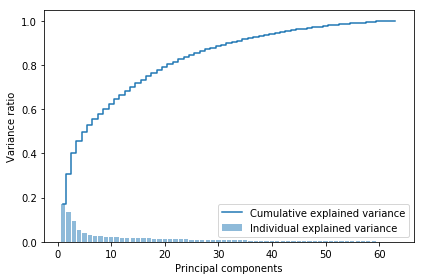

In [128]:
# Plot the variance

cumulative_variance = [variance[0]]
for i in range(1, len(variance)):
    cumulative_variance.append(cumulative_variance[i - 1] + variance[i])

# Plot the explained variance ratio for each principal component
plt.bar(range(1, len(variance) + 1), variance, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [129]:
cum_sum = 0

for i in range(0,36):
    cum_sum += variance[i]

print(cum_sum)

0.922687560383


In [130]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components = 35)
df_pca = pca.fit_transform(scaled_df)


In [131]:
df_pca.shape

(797426, 35)

### Discussion 2.2: Perform Dimensionality Reduction

35 principal components have been preserved since the cumulative variance adds up to 92.37% while reducing the no. of features by 45%

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [56]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_weights(pca, i):
    df = pd.DataFrame(pca.components_, columns=list(scaled_df.columns))
    weights = df.iloc[i].sort_values(ascending=False)
    return weights

pca_weight_0 = pca_weights(pca, 0)
print(pca_weight_0)

PLZ8_ANTG3               0.227519
PLZ8_ANTG4               0.220724
WEALTH                   0.208046
HH_EINKOMMEN_SCORE       0.204347
ORTSGR_KLS9              0.198128
EWDICHTE                 0.196320
FINANZ_HAUSBAUER         0.163246
PLZ8_ANTG2               0.154747
KBA05_ANTG4              0.153752
ARBEIT                   0.144362
FINANZ_SPARER            0.143389
ANZ_HAUSHALTE_AKTIV      0.136636
RELAT_AB                 0.136177
KBA05_ANTG3              0.135945
SEMIO_PFLICHT            0.112439
SEMIO_REL                0.109611
MOVEMENT                 0.107217
DECADE                   0.098122
SEMIO_RAT                0.092333
SEMIO_TRADV              0.085881
SEMIO_MAT                0.076792
SEMIO_FAM                0.075627
REGIOTYP                 0.073178
FINANZ_UNAUFFAELLIGER    0.070771
SEMIO_KULT               0.070172
FINANZ_ANLEGER           0.066876
OST_WEST_KZ              0.054258
KKK                      0.044007
SEMIO_SOZ                0.042122
PLZ8_HHZ      

In [57]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_1 = pca_weights(pca, 1)
print(pca_weight_1)

ALTERSKATEGORIE_GROB     0.261305
FINANZ_VORSORGER         0.233955
SEMIO_ERL                0.231310
SEMIO_LUST               0.184299
RETOURTYP_BK_S           0.163727
W_KEIT_KIND_HH           0.119348
FINANZ_HAUSBAUER         0.116000
SEMIO_KRIT               0.114871
SEMIO_KAEM               0.111875
ANREDE_KZ                0.090354
PLZ8_ANTG3               0.089568
EWDICHTE                 0.088662
ORTSGR_KLS9              0.087250
PLZ8_ANTG4               0.085539
WEALTH                   0.072187
SEMIO_DOM                0.070467
FINANZ_MINIMALIST        0.068390
KBA05_ANTG4              0.066462
ARBEIT                   0.065618
RELAT_AB                 0.063024
PLZ8_ANTG2               0.061664
WOHNDAUER_2008           0.061530
ANZ_HAUSHALTE_AKTIV      0.061410
HH_EINKOMMEN_SCORE       0.054339
KBA05_ANTG3              0.040948
ANZ_HH_TITEL             0.030584
OST_WEST_KZ              0.025156
REGIOTYP                 0.020930
MOVEMENT                 0.012689
PLZ8_HHZ      

In [58]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_2 = pca_weights(pca, 2)
print(pca_weight_2)

SEMIO_VERT               0.345236
SEMIO_SOZ                0.262269
SEMIO_FAM                0.250073
SEMIO_KULT               0.235363
FINANZ_MINIMALIST        0.155835
RETOURTYP_BK_S           0.108589
FINANZ_VORSORGER         0.101128
W_KEIT_KIND_HH           0.090939
ALTERSKATEGORIE_GROB     0.079179
SEMIO_REL                0.069736
SEMIO_LUST               0.064715
SEMIO_MAT                0.055995
GREEN_AVANTGARDE         0.046814
ORTSGR_KLS9              0.046108
EWDICHTE                 0.045463
PLZ8_ANTG4               0.045170
PLZ8_ANTG3               0.044778
ARBEIT                   0.034747
WOHNDAUER_2008           0.033079
RELAT_AB                 0.031596
PLZ8_ANTG2               0.029844
WEALTH                   0.027656
KBA05_ANTG4              0.026895
ANZ_HAUSHALTE_AKTIV      0.025486
OST_WEST_KZ              0.015398
ANZ_HH_TITEL             0.013316
ANZ_TITEL                0.009677
KBA05_ANTG3              0.007982
PLZ8_HHZ                 0.003920
SOHO_KZ       

### Discussion 2.3: Interpret Principal Components

<b>First component:</b> 
PLZ8_ANTG3 (Number of 6-10 family houses in the PLZ8 region) and PLZ8_ANTG4 (Number of 10+ family houses in the PLZ8 region) have a high positive correlation. PLZ8_ANTG1 (Number of 1-2 family houses in the PLZ8 region) has a high negative correlation with PLZ8_ANTG3. 

<b>Second component:</b>
ALTERSKATEGORIE_GROB (Estimated age based on given name analysis) and FINANZ_VORSORGER (be-prepared financial topology type) have high positive correlation. SEMIO_ERL(Event-oriented personality) and SEMIO_TRADV (tradional-minded personality have high negative correlation).

<b>Third component:</b>
SEMIO_VERT (dreamful persoanlity) and SEMIO_SOZ (socially-minded personality) have high positive correlation. Also, SEMIO_SOZ has high negative correlation with  SEMIO_KRIT (critical-minded personality).


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

In [64]:
from sklearn.cluster import KMeans
# Over a number of different cluster counts...
n_clusters = [2, 4, 6, 8, 10, 15, 20, 30]

# Function to obtain based on cluster counts

def score(data, c):
    kmeans = KMeans(c)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

In [65]:
# run k-means clustering on the data and compute the average within-cluster distances
scores = []

for c in n_clusters:
    s = score(df_pca, c)
    scores.append(s)
    
print(scores)

[39625529.237257481, 34260996.607194573, 31544468.70417618, 29553054.926555686, 28387737.738087736, 26346017.835305512, 24748089.262917943, 22741362.468839869]


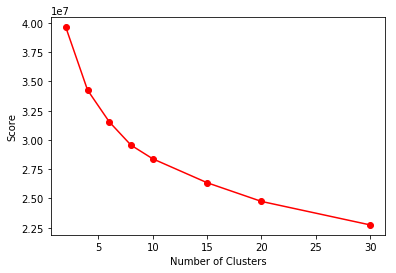

In [66]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(n_clusters, scores, marker = 'o', color = 'red')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()

In [171]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(15)
model = kmeans.fit(df_pca)
pca_gp = model.predict(df_pca)

### Discussion 3.1: Apply Clustering to General Population

Using the elbow method, the selected number of clusters is 15

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

In [147]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')
customers.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0
5,1,3,1,4.0,5,1,5,1,2,3,...,2.0,3.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0
6,2,4,1,2.0,5,1,5,1,1,2,...,3.0,2.0,1.0,0.0,1.0,5.0,5.0,2.0,3.0,2.0
7,1,4,1,2.0,5,1,5,1,2,2,...,3.0,3.0,1.0,1.0,1.0,3.0,3.0,3.0,4.0,3.0
8,2,4,2,1.0,2,2,5,1,1,5,...,1.0,4.0,2.0,1.0,5.0,5.0,4.0,3.0,8.0,3.0
9,1,3,1,3.0,5,2,4,1,3,1,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,3.0,6.0,4.0


Data after missing value conversions:


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,4.0,1.0,5.0,5.0,1.0,5.0,1.0,2.0,2.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,NaN,4.0,1.0,NaN,5.0,1.0,5.0,1.0,3.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,4.0,2.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1.0,4.0,1.0,2.0,5.0,1.0,5.0,2.0,1.0,2.0,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,NaN,3.0,1.0,6.0,3.0,1.0,4.0,4.0,5.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


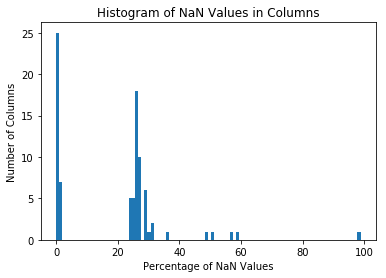

Data after removal of selected columns:


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,4.0,1.0,5.0,5.0,1.0,5.0,1.0,2.0,2.0,2.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,4.0,1.0,NaN,5.0,1.0,5.0,1.0,3.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,2.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,2.0,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,4.0,1.0,2.0,5.0,1.0,5.0,2.0,1.0,2.0,6.0,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,3.0,1.0,6.0,3.0,1.0,4.0,4.0,5.0,2.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


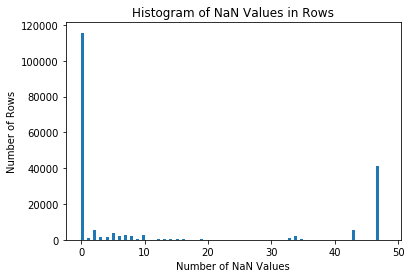

Data after removal of selected rows and columns:


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,4.0,1.0,5.0,5.0,1.0,5.0,1.0,2.0,2.0,2.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
2,4.0,2.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,2.0,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,4.0,1.0,2.0,5.0,1.0,5.0,2.0,1.0,2.0,6.0,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,3.0,1.0,6.0,3.0,1.0,4.0,4.0,5.0,2.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0
5,3.0,1.0,4.0,5.0,1.0,5.0,1.0,2.0,3.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0


After binary and multi-category handling:


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5821: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1,1.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
2,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1,2.0,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0,2.0,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0
5,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFESTAGE
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1,1.0,...,0.0,5.0,5.0,1.0,2.0,1.0,2.0,0.0,1.0,3.0
2,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1,2.0,...,1.0,3.0,2.0,3.0,5.0,3.0,2.0,0.0,3.0,4.0
3,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0,2.0,...,0.0,3.0,4.0,1.0,3.0,1.0,1.0,1.0,2.0,4.0
4,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0,3.0,...,1.0,3.0,3.0,3.0,5.0,1.0,4.0,1.0,4.0,1.0
5,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1,3.0,...,1.0,5.0,5.0,3.0,7.0,5.0,2.0,0.0,3.0,4.0
6,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1,2.0,...,0.0,5.0,5.0,2.0,3.0,2.0,2.0,0.0,2.0,3.0
7,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1,1.0,...,1.0,3.0,3.0,3.0,4.0,3.0,2.0,0.0,1.0,5.0
8,4.0,2.0,2.0,2.0,5.0,1.0,1.0,5.0,0,2.0,...,1.0,5.0,4.0,3.0,8.0,3.0,1.0,1.0,5.0,5.0
9,3.0,1.0,5.0,2.0,4.0,1.0,3.0,1.0,1,3.0,...,0.0,5.0,5.0,3.0,6.0,4.0,4.0,0.0,1.0,5.0
11,4.0,1.0,5.0,1.0,5.0,1.0,3.0,2.0,1,1.0,...,0.0,3.0,3.0,2.0,5.0,1.0,2.0,0.0,1.0,4.0


In [169]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean = clean_data(customers)
customers_clean.head(10)

In [175]:
dfimp = imputer.transform(customers_clean)
dfimp = pd.DataFrame(dfimp, columns=customers_clean.columns)
cimp = scaler.transform(dfimp)
cpca = pca.transform(cimp)
pca_cd = model.predict(cpca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'General Clusters')

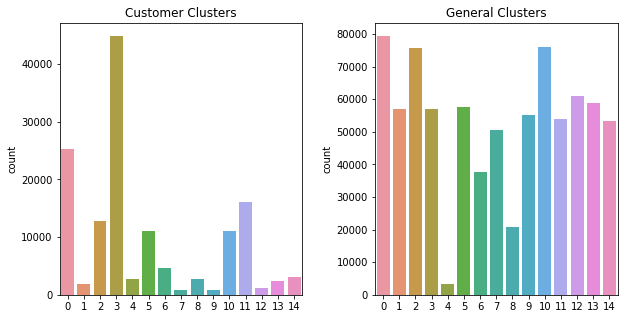

In [176]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
figure.subplots_adjust(hspace = 1, wspace=.3)

sns.countplot(pca_cd, ax=axs[0])
axs[0].set_title('Customer Clusters')
sns.countplot(pca_gp, ax=axs[1])
axs[1].set_title('General Clusters')

In [177]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

cluster_3 = model.cluster_centers_[3]
pca_3 = pca.inverse_transform(cluster_3)
overrepresented = scaler.inverse_transform(pca_3)

overrepresented = pd.Series(data = overrepresented, index = customers_clean.columns)
overrepresented

ALTERSKATEGORIE_GROB        3.308372
ANREDE_KZ                   1.054971
FINANZ_MINIMALIST           4.832672
FINANZ_SPARER               1.638143
FINANZ_VORSORGER            4.181570
FINANZ_ANLEGER              1.526361
FINANZ_UNAUFFAELLIGER       2.167578
FINANZ_HAUSBAUER            1.915663
GREEN_AVANTGARDE            0.990120
HEALTH_TYP                  2.081425
RETOURTYP_BK_S              3.967398
SEMIO_SOZ                   4.862824
SEMIO_FAM                   4.827208
SEMIO_REL                   3.733066
SEMIO_MAT                   3.919909
SEMIO_VERT                  6.220610
SEMIO_LUST                  5.227156
SEMIO_ERL                   4.108148
SEMIO_KULT                  4.899676
SEMIO_RAT                   2.686688
SEMIO_KRIT                  3.139330
SEMIO_DOM                   3.325727
SEMIO_KAEM                  2.636067
SEMIO_PFLICHT               3.189826
SEMIO_TRADV                 3.124649
SOHO_KZ                     0.008701
ANZ_PERSONEN                2.218432
A

In [178]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cluster_9 = model.cluster_centers_[9]
pca_9 = pca.inverse_transform(cluster_9)
overrepresented = scaler.inverse_transform(pca_9)

underrepresented = pd.Series(data = overrepresented, index = customers_clean.columns)
underrepresented

ALTERSKATEGORIE_GROB        1.772867
ANREDE_KZ                   1.969960
FINANZ_MINIMALIST           1.410490
FINANZ_SPARER               4.235144
FINANZ_VORSORGER            2.336107
FINANZ_ANLEGER              4.361539
FINANZ_UNAUFFAELLIGER       3.876791
FINANZ_HAUSBAUER            3.962179
GREEN_AVANTGARDE            0.069246
HEALTH_TYP                  2.285734
RETOURTYP_BK_S              2.566749
SEMIO_SOZ                   2.812730
SEMIO_FAM                   3.958629
SEMIO_REL                   5.325646
SEMIO_MAT                   5.009912
SEMIO_VERT                  2.343584
SEMIO_LUST                  3.335768
SEMIO_ERL                   4.307907
SEMIO_KULT                  4.023969
SEMIO_RAT                   5.972326
SEMIO_KRIT                  5.475882
SEMIO_DOM                   5.908747
SEMIO_KAEM                  5.617103
SEMIO_PFLICHT               6.060785
SEMIO_TRADV                 5.431218
SOHO_KZ                     0.008059
ANZ_PERSONEN                1.500593
A

### Discussion 3.3: Compare Customer Data to Demographics Data


From the above analysis, the following can be concluded:

Cluster 3 is overrepresented in the customers data compared to general population data. Some characteristics of the group of population that are relative popular with the mail-order company are as follows:

a) PLZ8_ANTG3=1.73 : where number of 6-10 family houses is low

b) WEALTH=2.06 : with the prosperous households

c) LIFE_STAGE=3.60 : families with scool age children

Cluster 9 is underrepresented in the customers data compared to general population data. Some characteristics of the population group that are relatively unpopular with the company:

a) KBA05_ANTG1=1.01: where the share of 1-2 family houses is lower 

b) MOBI_REGIO=2.58: people with middle movement patterns tending to high movement

c) BALLRAUM=4.49: places where the distance to the nearest urban center is 35 Km